<a href="https://colab.research.google.com/github/Iguta/ZTM-DeepLearningWithPyTorch/blob/main/Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiclass classification

In [187]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [188]:
#creating a toy multi-class dataset
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
X, y = make_blobs(n_samples = NUM_SAMPLES,
                  n_features = NUM_FEATURES,
                  centers = NUM_CLASSES,
                  cluster_std=1.5)

In [189]:
X[:5], y[:5]

(array([[ -5.29523773,   5.77978768],
        [ -4.36716419,   5.7481095 ],
        [-11.49417526,   3.29791686],
        [ -2.59942849,   4.89319554],
        [  1.79913423,   3.34856129]]),
 array([1, 1, 2, 1, 3]))

In [190]:
X.shape, y.shape

((1000, 2), (1000,))

In [191]:
#Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [192]:
y.dtype

torch.float32

In [193]:
torch.unique(y)

tensor([0., 1., 2., 3.])

In [194]:
#split into test and train
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=101)
len(X_train), len(y_train)

(700, 700)

Text(0.5, 1.0, 'Scatter Plot: X2 vs. X1 features')

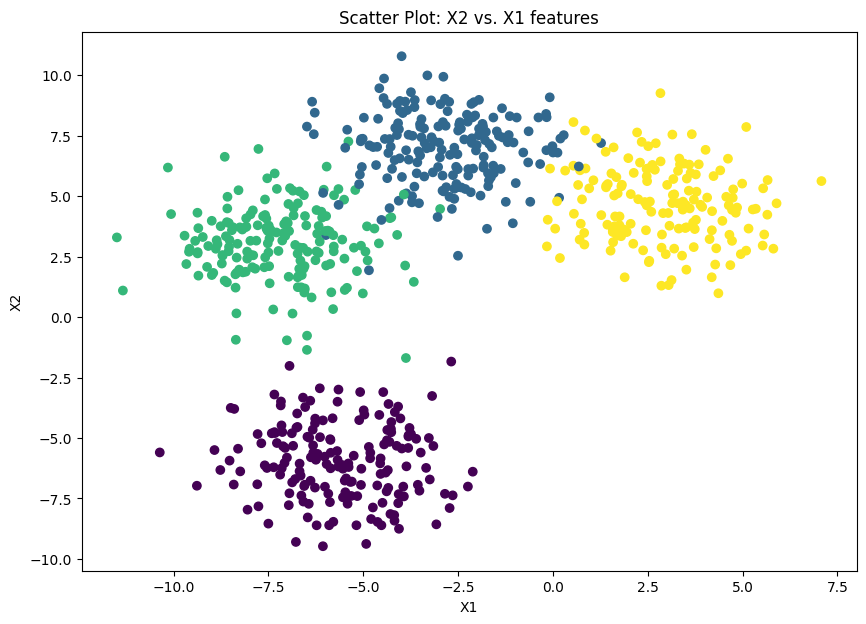

In [195]:
#plot the data -> Visualize the training set
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter Plot: X2 vs. X1 features")

In [196]:
#using plotly -> just because we can :)
import plotly.express as px
fig = px.scatter(x=X_train[:, 0], y=X_train[:,1], color=y_train)
fig.show()

### Device Agnostic code

In [197]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Build the Model

In [198]:
class MultiClassNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(2, 10),
        nn.ReLU(),
        nn.Linear(10, 100),
        nn.ReLU(),
        nn.Linear(100, 20),
        nn.ReLU(),
        nn.Linear(20, 4) # -> this has our logits
    )
  def forward(self, x):
    return self.layers(x)

In [199]:
#intialize our model
model = MultiClassNN().to(device)
model

MultiClassNN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)

### Training The Model

In [200]:
### define an accuracy helper function
def accuracy(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

In [201]:
#define our loss and optimizer -> We use Cross Entropy loss here because we are dealing with multi-classes
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                               lr=0.1)

In [202]:
#logits from our model - raw outputs of our model
model.eval()
with torch.inference_mode():
  y_logits = model(X_train[:5, ].to(device))
y_logits

tensor([[ 0.1917,  0.5134, -0.1009, -0.6328],
        [ 0.2268,  0.5920, -0.1673, -0.5967],
        [ 0.0921,  0.5304, -0.0432, -0.6619],
        [ 0.0273,  0.3005, -0.1543, -0.1789],
        [-0.1870,  0.5329, -0.2247, -0.3473]], device='cuda:0')

In [203]:
y_train[:5, ]

tensor([2., 1., 2., 3., 0.])

In [204]:
### we need to convert these logits into prediction probabilities and then into prediction labels

In [205]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs

tensor([[0.2806, 0.3870, 0.2094, 0.1230],
        [0.2814, 0.4054, 0.1897, 0.1235],
        [0.2568, 0.3981, 0.2243, 0.1208],
        [0.2524, 0.3317, 0.2105, 0.2054],
        [0.2054, 0.4219, 0.1978, 0.1750]], device='cuda:0')

In [206]:
#the probabilities sum up to 1
y_pred_probs[:1, ].sum()

tensor(1.0000, device='cuda:0')

In [207]:
#getting the max probability
print(f"Maximum probability: {y_pred_probs.max():.2f}")
print(f"Class with maximum probability: {y_pred_probs[1].argmax()}")

Maximum probability: 0.42
Class with maximum probability: 1


In [208]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 1, 1, 1, 1], device='cuda:0')

In [209]:
y_logits.shape

torch.Size([5, 4])

In [210]:
#Training Loop
def train(X_train, y_train, X_test, y_test):
  #ensure all tensors are on the same device
  X_train = X_train.to(device)
  y_train = y_train.long().to(device) #-> we need to convert the y_train, and y_test labels so as to work well with crossEntropy
  X_test = X_test.to(device)
  y_test = y_test.long().to(device)

  epochs = 300
  #tracking train acc, test acc, train loss and test loss
  train_loss_hist = []
  test_loss_hist = []
  train_acc_hist = []
  test_acc_hist = []

  #training loop
  for epoch in range(epochs):
    #set model to train mode
    model.train()

    #forward pass
    y_pred_logits = model(X_train)
    # print(y_pred_logits[:5])
    #get the probabilities for each class
    y_pred_probs =  torch.softmax(y_pred_logits, dim=1)
    #get the class with the highest probability
    # print(y_pred_probs[:5])
    y_pred_label = torch.argmax(y_pred_probs, dim=1)

    #evaluate the training loss
    loss = loss_fn(y_pred_logits, y_train)
    # print(loss.item())

    #evaluate accuracy of the model
    train_acc = accuracy(y_pred_label, y_train)
    #optimize zero grad
    optimizer.zero_grad()

    #backward propagation
    loss.backward()

    #optimize the parameters of the model
    optimizer.step()

    #evaluate the model
    model.eval()
    with torch.inference_mode():
      #forward pass
      y_test_logits = model(X_test)
      #get the probabilities for each class
      y_test_probs =  torch.softmax(y_test_logits, dim=1)
      #get the class with the highest probability
      y_test_label = torch.argmax(y_test_probs, dim=1)

      #get test loss
      test_loss = loss_fn(y_test_logits, y_test)
      #get the test accuracy
      test_acc =  accuracy(y_test_label, y_test)

    #track accuracy and loss
    train_loss_hist.append(loss.item())
    test_loss_hist.append(test_loss.item())
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

    #print what is happening
    if epoch %100 ==0:
      print(f"Epoch {epoch} | Training Loss {loss.item():.5f} | Test Loss {test_loss.item():.5f} | Train Accuracy {train_acc:.2f}% | Test Accuracy {test_acc:.2f}%")
  return train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist

In [211]:
train_loss, test_loss, train_acc, test_acc = train(X_train, y_train, X_test, y_test)

Epoch 0 | Training Loss 1.38365 | Test Loss 1.25814 | Train Accuracy 26.00% | Test Accuracy 22.67%
Epoch 100 | Training Loss 0.07936 | Test Loss 0.09060 | Train Accuracy 97.43% | Test Accuracy 98.00%
Epoch 200 | Training Loss 0.07480 | Test Loss 0.08983 | Train Accuracy 97.43% | Test Accuracy 97.33%


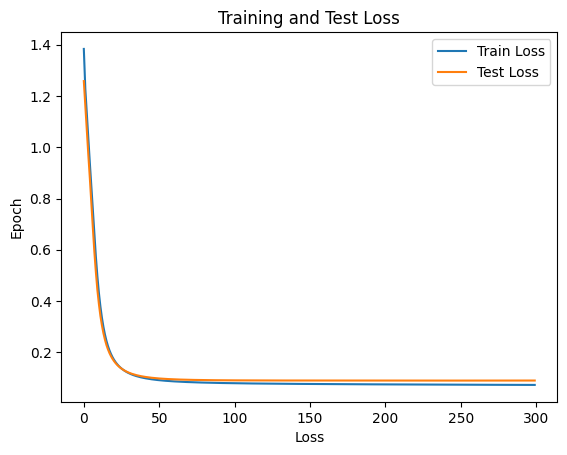

In [212]:
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Training and Test Loss")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

### Evaluate the model


In [213]:
model.eval()
with torch.inference_mode():
  y_labels = model(X_test.to(device)).softmax(dim=1).argmax(dim=1)
  test_accuracy = accuracy(y_labels, y_test.to(device))
print(f"Model Accuracy: {test_accuracy:.2f}%")

Model Accuracy: 97.00%


In [217]:
#download helper function from Learn Pytorch repo
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file already exists. SKipping download...")
else:
  request =  requests("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as  f:
    f.write(request.content)


file already exists. SKipping download...


In [218]:
from helper_functions import plot_decision_boundary

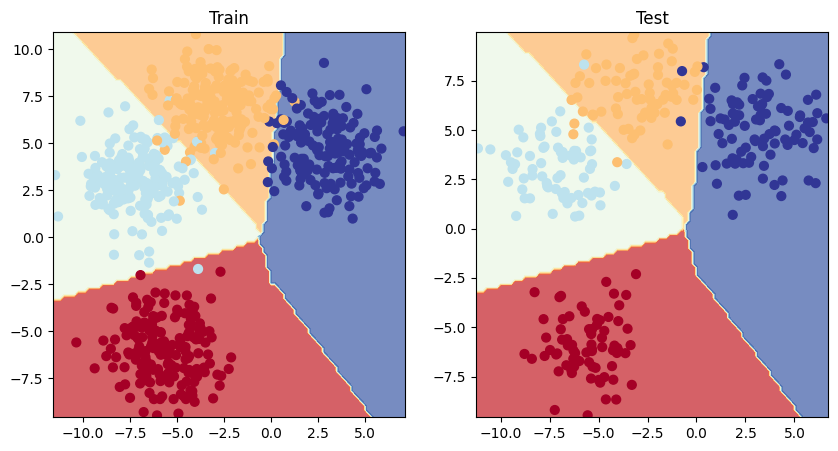

In [224]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [225]:
from sklearn.metrics import classification_report, confusion_matrix

In [227]:
print(classification_report(y_test.cpu().numpy(), y_labels.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        73
         1.0       0.94      0.93      0.93        68
         2.0       0.93      0.99      0.96        69
         3.0       1.00      0.97      0.98        90

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [228]:
print(confusion_matrix(y_test.cpu().numpy(), y_labels.cpu().numpy()))

[[73  0  0  0]
 [ 0 63  5  0]
 [ 0  1 68  0]
 [ 0  3  0 87]]


In [231]:
import seaborn as sns
import plotly.express as px
cf = confusion_matrix(y_test.cpu().numpy(), y_labels.cpu().numpy())
# sns.heatmap(cf)
px.imshow(cf)